/home/aas926/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/tmp/ipykernel_2890507/4053495802.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_2890507/4053495802.py:82: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


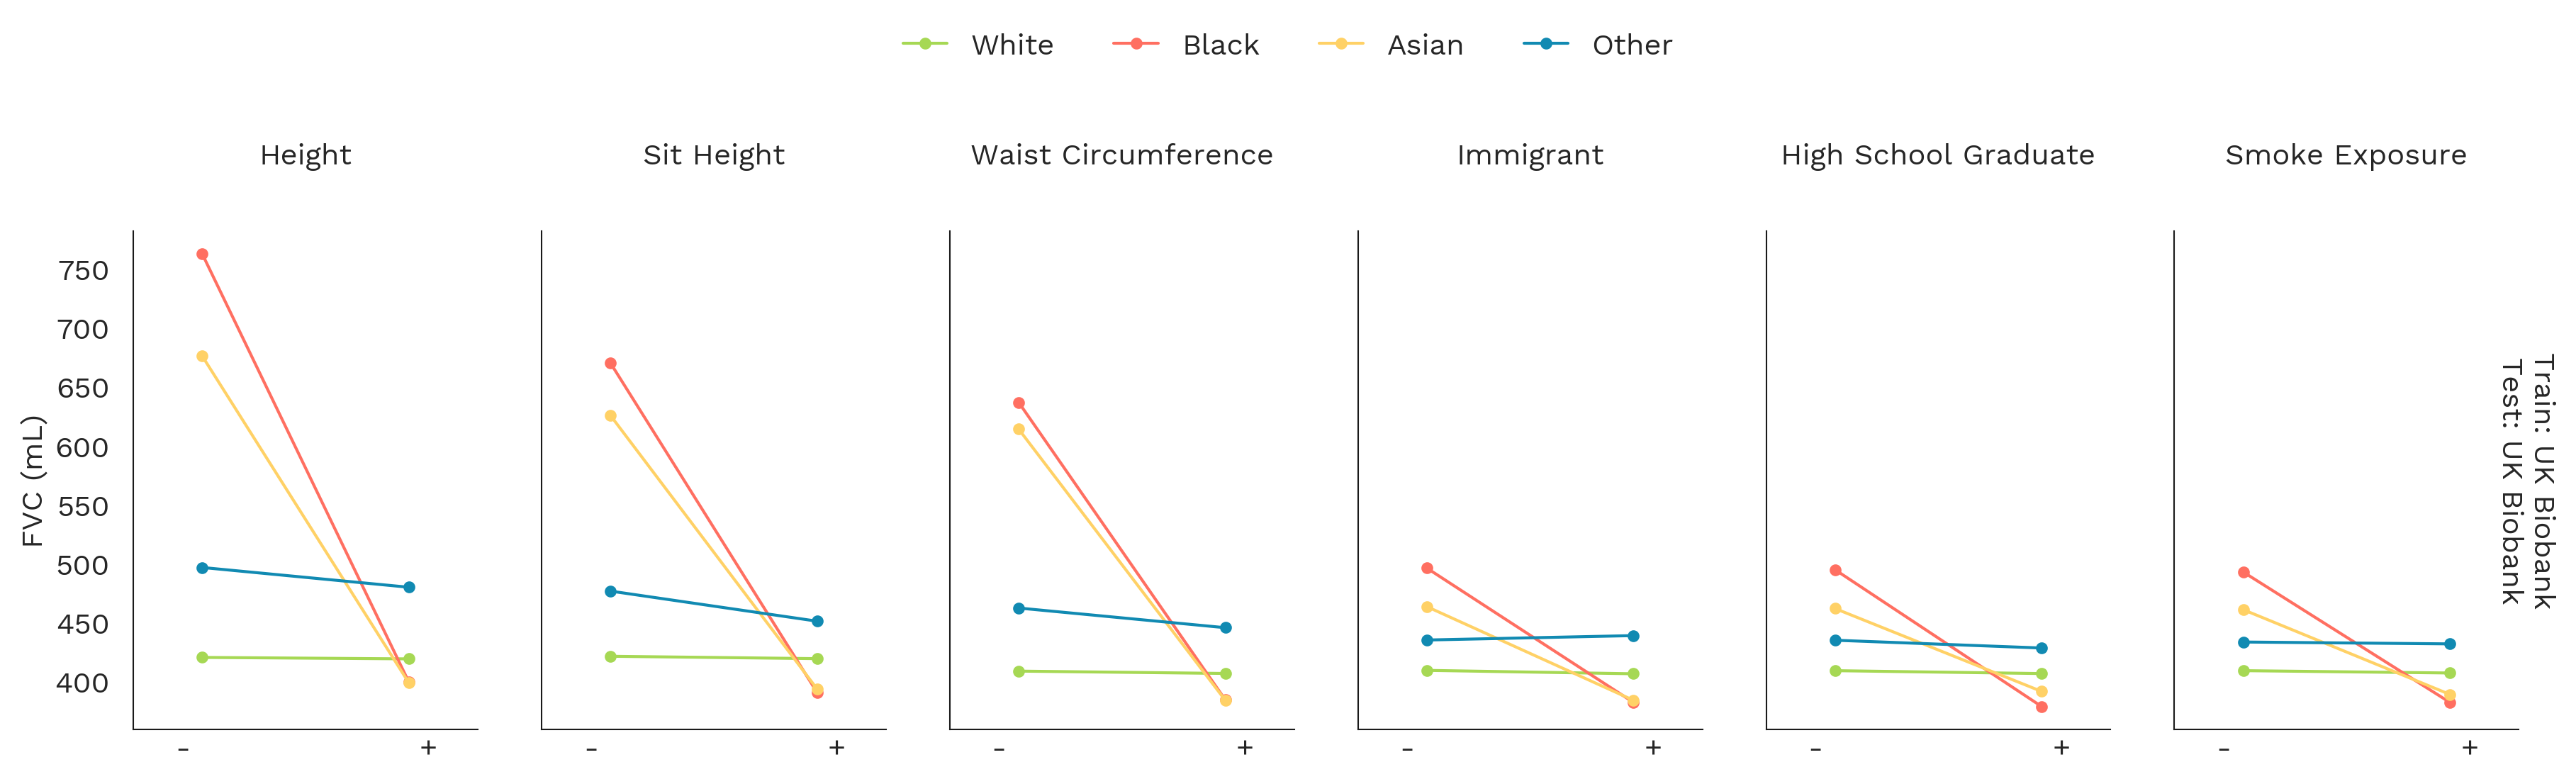

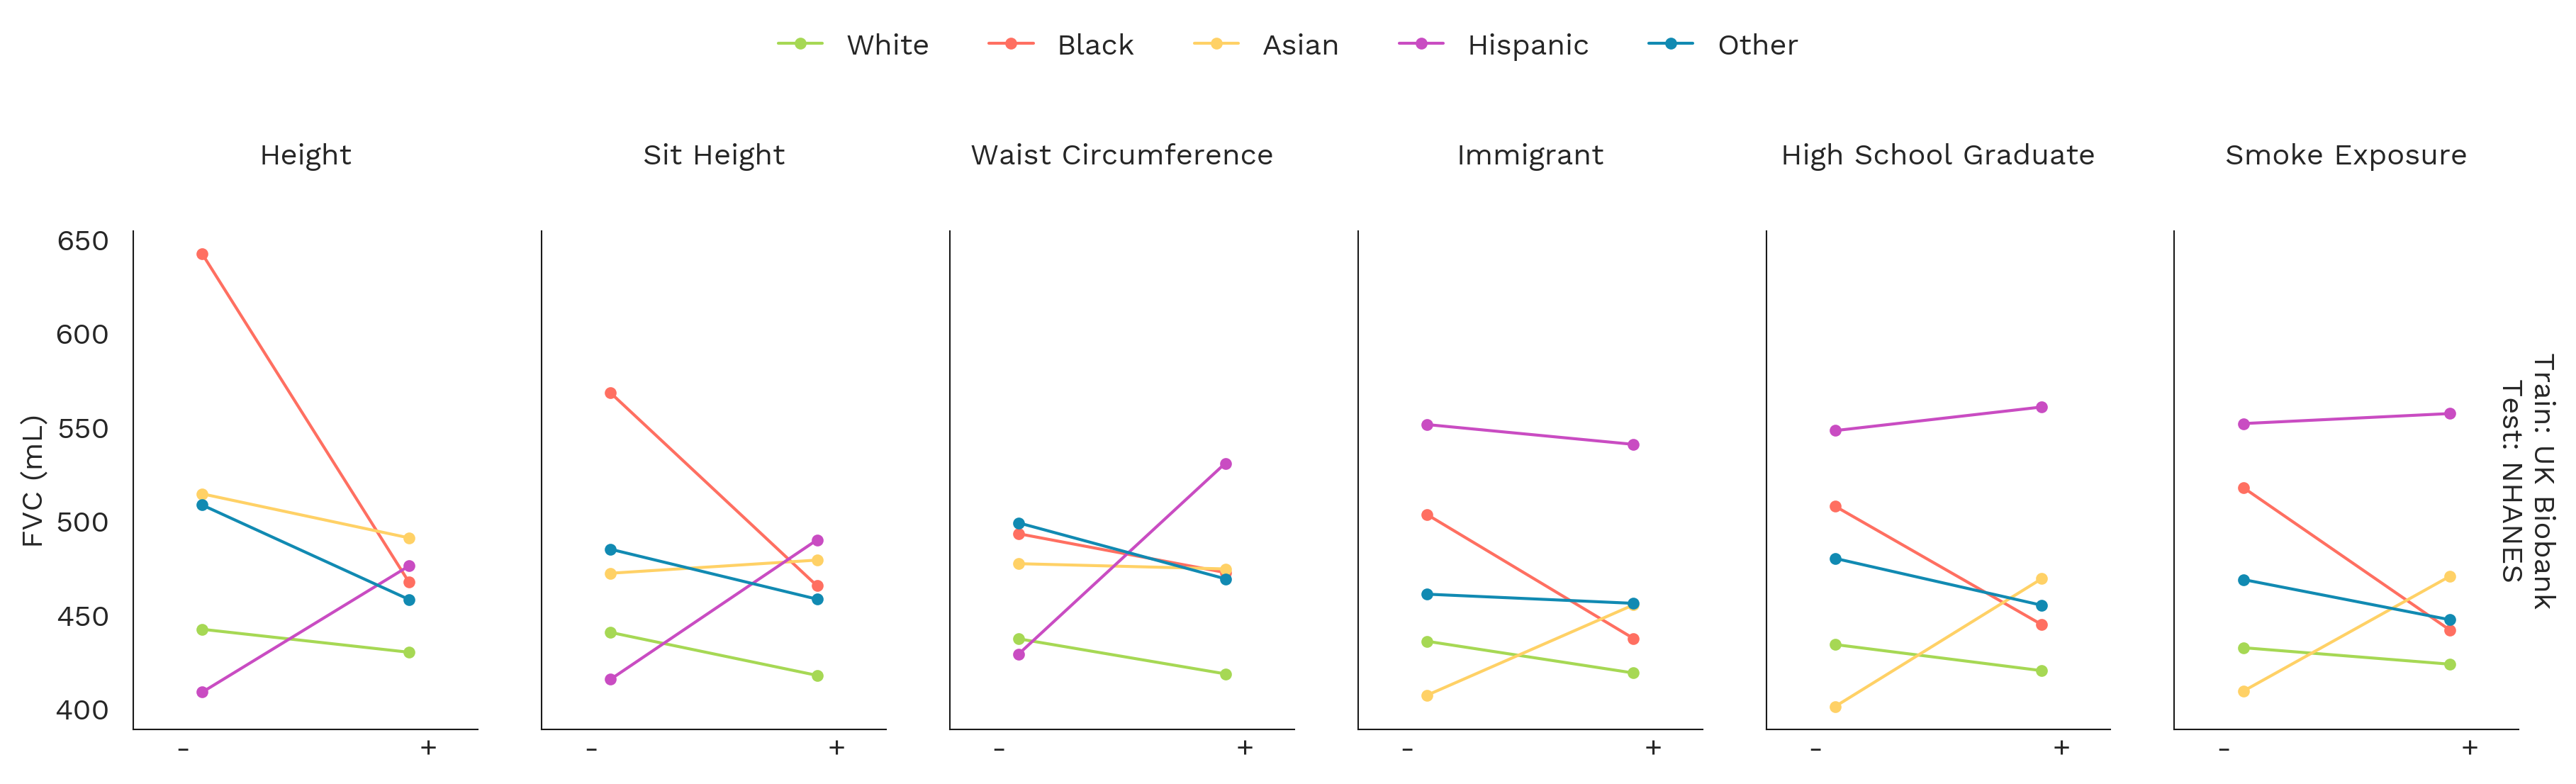

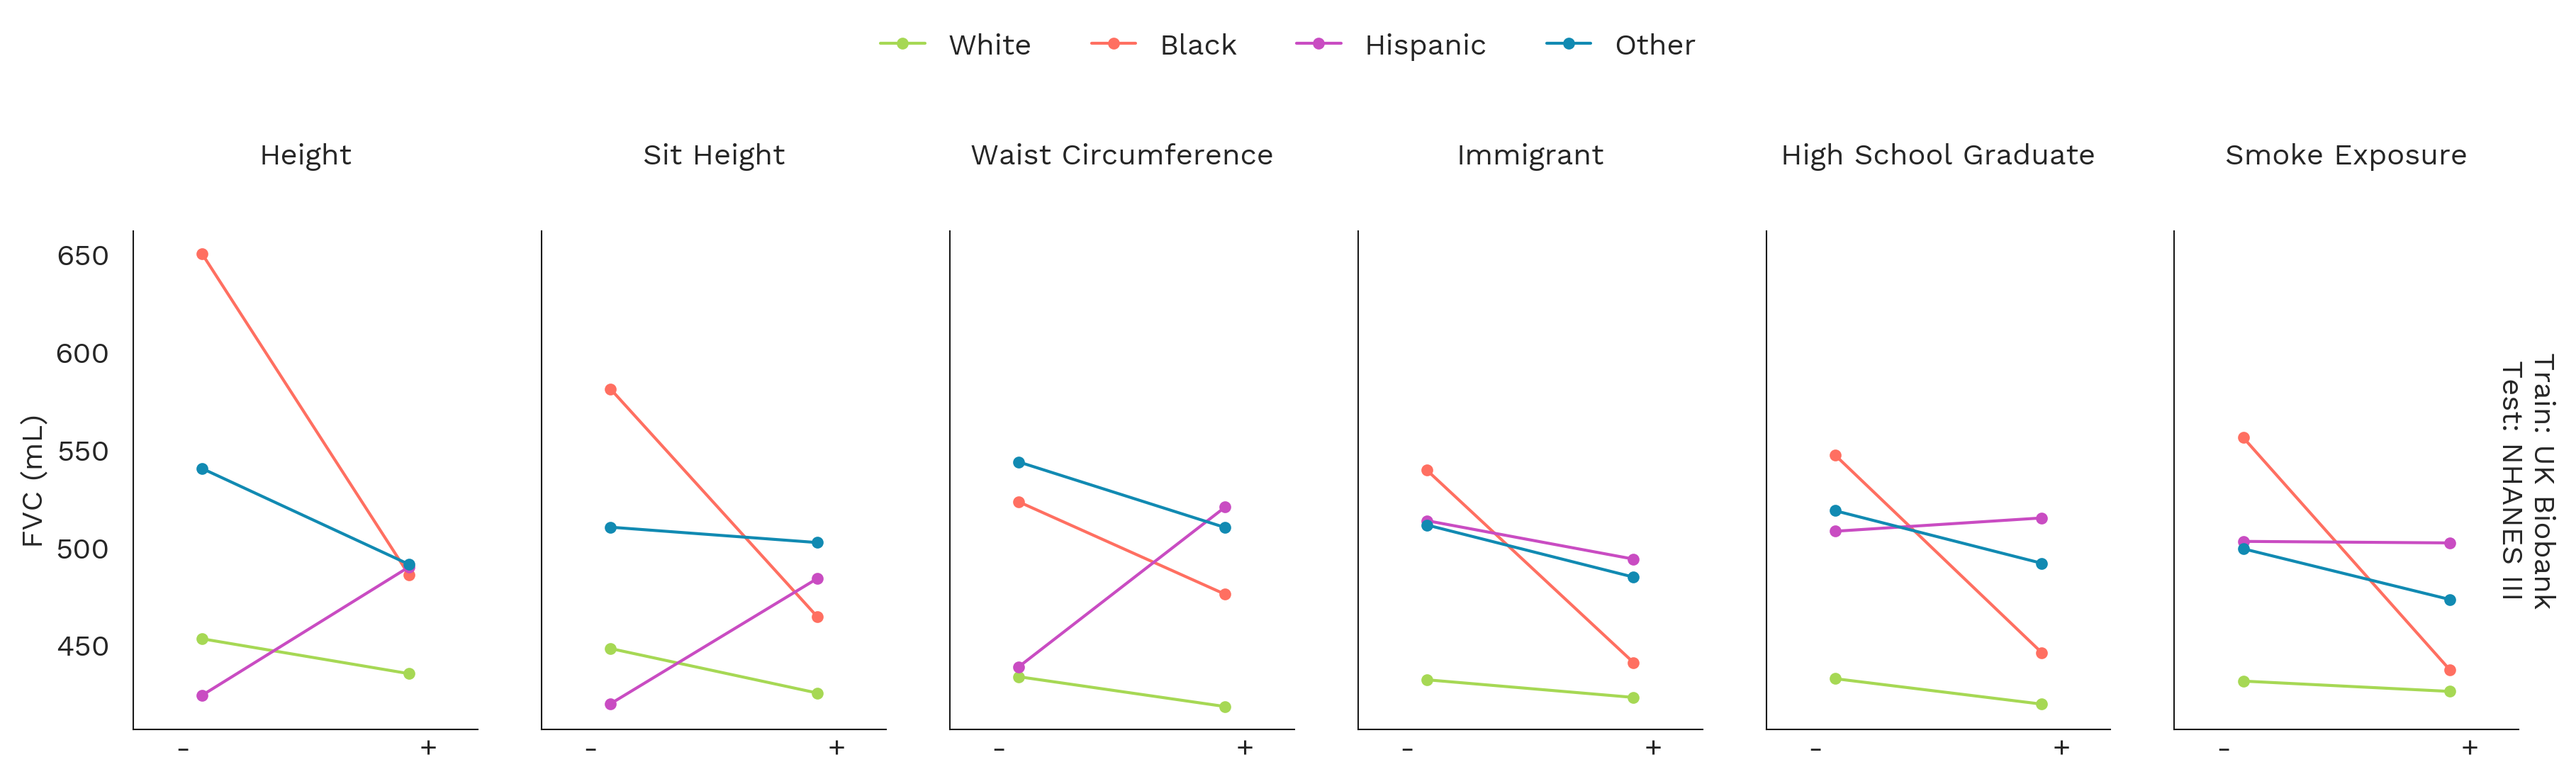

In [ ]:
import pandas as pd
import sys

sys.path.append('../')
from data.dicts.col_dict import *
from helpers.plots import *
plt.rcParams.update(rc)

def plot_metric_panels(
    df,
    target,
    train,
    test,
    save_path,
    metric="mae",
    cov_order=None,
    groups_order=None,
    exclude_all=True,
    ml_to_l=True,
    figsize_per_panel=(2, 3.0),
):
    """
    The x axis labels (by default hidden or "-", "+") correspond to the `race_adj` column:
      - The left tick (`x=0`) is for `race_adj == False`
      - The right tick (`x=1`) is for `race_adj == True`
    You can set ax.set_xticklabels(["No Race Adj", "Race Adj"]) to clarify.
    """

    d = df[(df["target"] == target) & (df["set"] == test)].copy()
    if exclude_all:
        d = d[d["group"].str.lower() != "all"]

    if cov_order is None:
        cov_order = list(dict.fromkeys(d["cov"].tolist()))
    if groups_order is None:
        groups_order = [g for g in d["group"].unique()]

    n_panels = len(cov_order)
    fig_w = max(6.0, figsize_per_panel[0] * n_panels)
    fig_h = figsize_per_panel[1]
    fig, axes = plt.subplots(1, n_panels, sharey=True, figsize=(fig_w, fig_h), gridspec_kw={'wspace': 0.15})
    if n_panels == 1:
        axes = [axes]

    x0, x1 = 0.0, 1.0
    xpad = 0.08

    # Each panel (covariate)
    for ax, cov in zip(axes, cov_order):
        dc = d[d["cov"] == cov]

        for g in groups_order:
            dg = dc[dc["group"] == g]
            
            y_false = dg.loc[dg["race_adj"] == False, metric]
            y_true  = dg.loc[dg["race_adj"] == True,  metric]
            
            y0 = float(y_false.iloc[0])
            y1 = float(y_true.iloc[0])
            
            ax.plot([x0 + xpad, x1 - xpad], [y0, y1], marker="o", label=g, color=r_colors[g])

        ax.set_title(str(cov), fontproperties=fp, y=1.1)
        ax.set_xlim(-0.2, 1.2)
        ax.set_xticks([x0, x1])
        ax.set_xticklabels(["-", "+"], fontproperties=fp)
        for t in ax.get_yticklabels():
            t.set_fontproperties(fp)

    ylab = f"{target.upper()} (mL)" if (ml_to_l and metric == "mae") else metric
    axes[0].set_ylabel(ylab, fontproperties=fp)

    handles, labels = axes[0].get_legend_handles_labels()
    labels = [label.title() for label in labels]
    if handles:
        fig.legend(handles, labels, ncols=min(len(labels), 6), loc="upper center",
                   bbox_to_anchor=(0.5, 1.2), frameon=False, prop=fp)
    title = "Train: " + cohort_dict[train.replace("_val", "")] + "\nTest: " + cohort_dict[test.replace("_val", "")]
    ax.text(1.02, 0.5, title,
        transform=ax.transAxes, rotation=-90, fontsize=10,
        va="center", ha="center",
    )
    fig.tight_layout()
    # please save the figure as a pdf with dpi=300
    plt.savefig(save_path, dpi=300)
    plt.show()
    return fig, axes

train = ['ukb', 'nh', 'nh3', 'nh4']
targets = ['fvc', 'fev1']

for target in targets:
    for t in train:
        path = f'../results/train/tables/metrics_train_{t}.csv'  
        df = pd.read_csv(path)
        for test in df.set.unique():
            df_test = df[df.set == test]
            save_path = f'../results/train/figures/{target}_t:{t}_v:{test}.pdf'
            plot_metric_panels(df, target=target, train=t, test=test, metric="mae", save=save_path=save_path)